# Diamond EP Grouping by Resolution Limit - Outliers

Previously analysis has shown how most of the features do not follow a normal distribution, and most have significant outliers which might be nonsensical data resulting from the "resolution limit expansion" process done when preprocessing the data.

In this notebook these outliers will try to be identified and somehow removed, which might result in a positive change to predictive model performance.

In [1]:
import sys
dirpath = r'C:\Users\César\PycharmProjects\Diamond_ML'
if dirpath not in sys.path:
    sys.path.insert(0, dirpath)
from read_data import data, pd, np, plt, plot_original_data
from grouping import cluster_spacegroups
from outliers import matrixdistplot
plt.style.use("ggplot")

DIALS


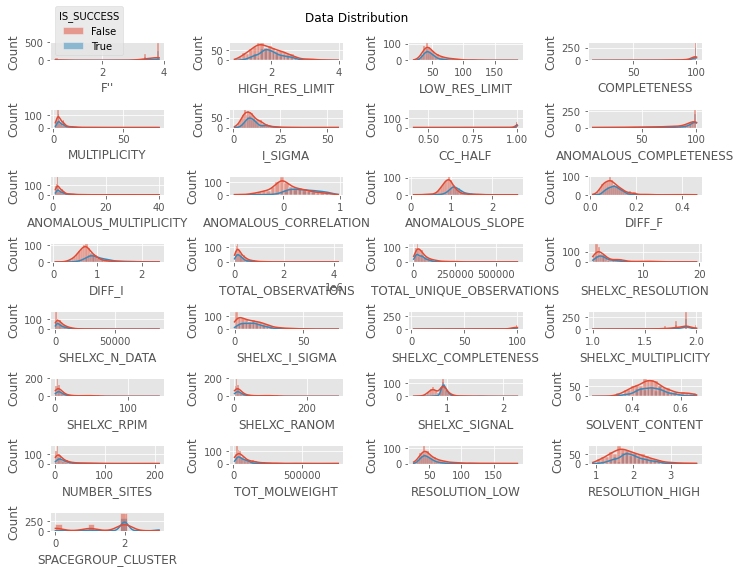

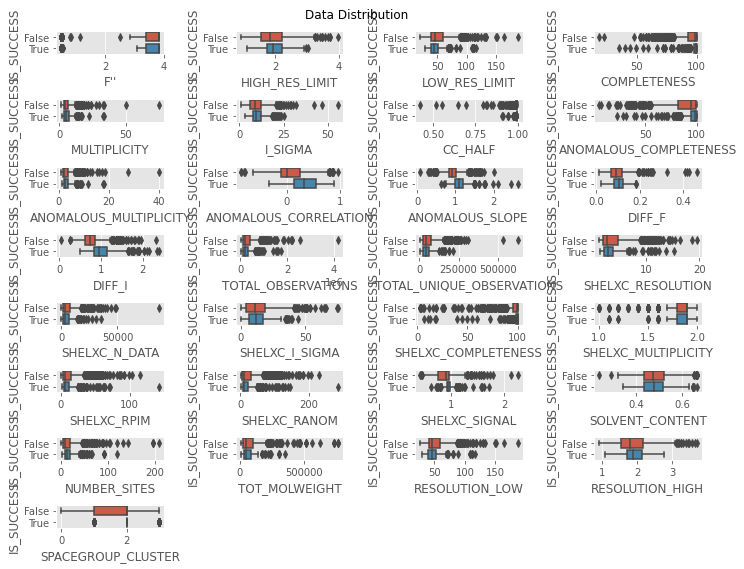

------------------------------------------------------------
3DII


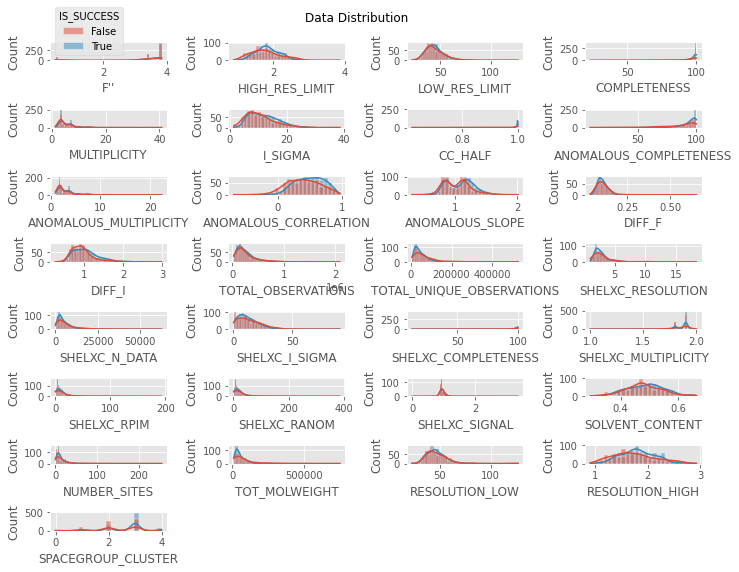

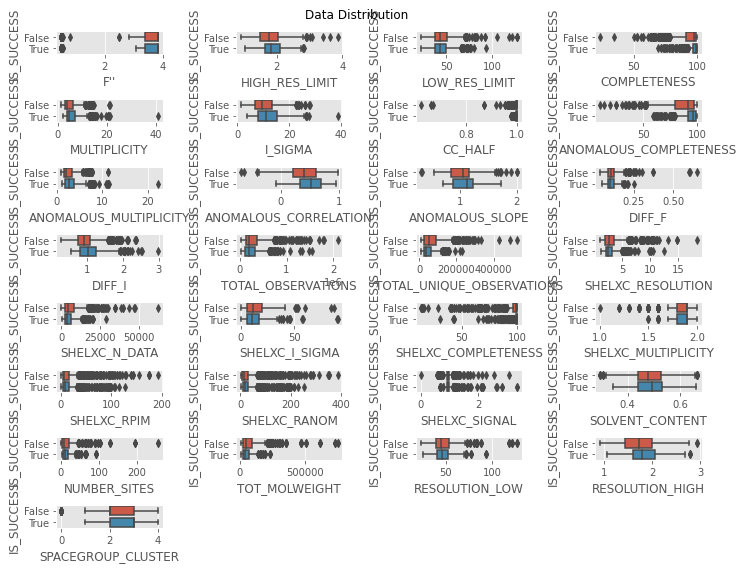

------------------------------------------------------------


In [3]:
import seaborn as sns
    

for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME"], axis=1)
    
    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    x = x.drop("SPACEGROUP", axis=1)
    union = pd.concat([x, y], axis=1)

    '''# group data
    groups = GroupedData(x, y)
    groups.group(x["DATASET_NAME"])
    
    # sort groups
    names = x["DATASET_NAME"].unique().tolist()
    names.sort()
    groups.sort(names, inplace=True)
    
    for i, group in groups:
        x, y = group.unpack()'''
    
    # plot histogram/boxplot matrix
    for kind in ["hist", "box"]:
        matrixdistplot(data=union, colnames=x.columns, kind=kind, target_label="IS_SUCCESS", show=False)
    
    plt.show()

    print("-"*60)

Most histograms show a long trail, indicating the presence of **significant outliers**, which is corroborated in the boxplots, showing large amounts of datapoints outside of the 25-75th percentiles.

However, **some features do not follow a normal/gaussian distribution**, such as the resolution limits, f'', dataset name and spacegroup cluster. These features possess discrete and/or clustered values, so outlier removal methods based on gaussian distributions should **not** be used with them. Instead, for these, a clustering method, such as LOC or Isolation Forests should be used.

It's important to realise that this is the case even for the "untouched" dataset.

## Scoring

In the following analysis, since the target is unbalanced, having more negatives than positives, accuracy will not be used as a performance indicative metric.

Instead, the **f1 score** (harmonic mean between precision and recall) will be used. The higher the f1 score, the better the performance.

Additionally, the **M**atthews **C**orrelation **C**oefficient, or **MCC**, is also going to be used. MCC ranges from -1 to 1, with a coefficient of +1 representing a perfect prediction, 0 an average random prediction and -1 an inverse prediction. As such, the higher, the better.


## Method 1 - Dataset/Limit Resolution Difference

Melanie's guess is that "the outliers are non-sense data were the actual measurement didn’t reach the resolution limits we asked the software to use". To check this, the dataset resolution label and the actual resolution limits need to be be compared.

In this method, the difference between the dataset resolution label (the resolution it should be, aka "RESOLUTION_LOW/HIGH"), and the actual resolution limit (aka "LOW/HIGH_RES_LIMIT") is taken. If this difference is above a predefined threshold, the sample is taken to be erroneous, and an **outlier**.

In the following analysis thresholds of 5 for the LR, and 0.1 for the HR were used.

However, if this method does successfully eliminate outliers, then these result from a software error, where it was unable to reach the resolution limit asked from it.

DIALS
Seed is: 1


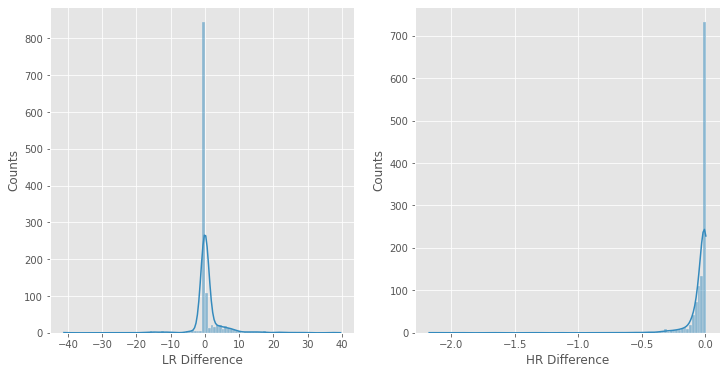

OG:
> Low: 1201 samples - MSE: 23.74
> High: 1201 samples - MSE: 0.0191
Masked:
> Low: 1074 samples - Dropped 127 (10.57%) - MSE: 1.21
> High: 1074 samples - Dropped 127 (10.57%) - MSE: 0.0009
No. of common outliers: 13
In total dropped 241 samples (20.07%)
> Score: OG = 80.50% +- 2.35% vs New = 80.69% +- 1.48%
> MCC: OG = 0.72 +- 0.03 vs New = 0.72 +- 0.02 


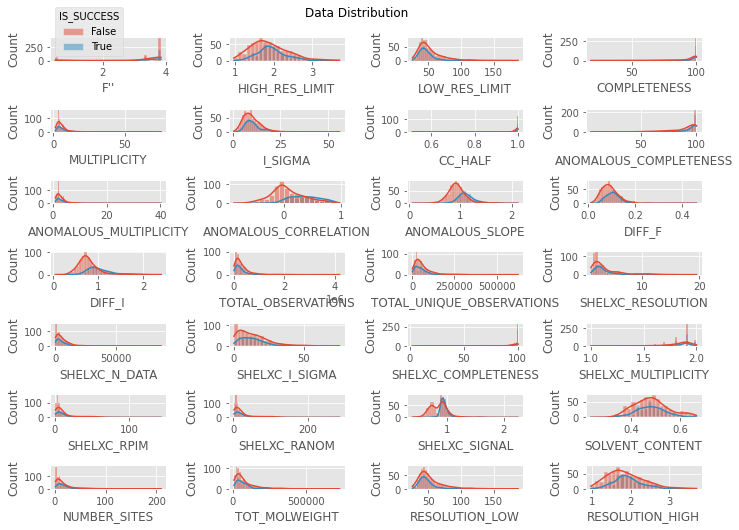

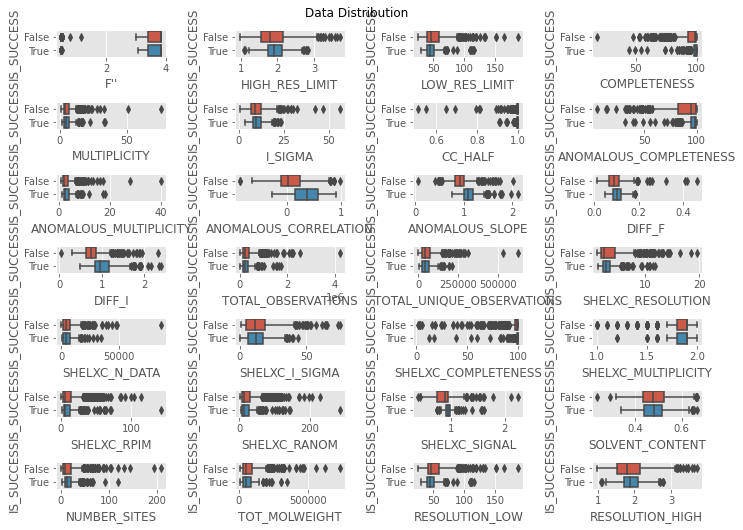

------------------------------------------------------------
3DII
Seed is: 1


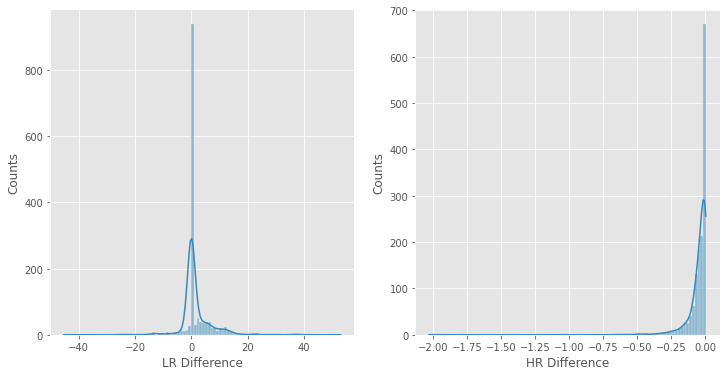

OG:
> Low: 1450 samples - MSE: 35.65
> High: 1450 samples - MSE: 0.0130
Masked:
> Low: 1167 samples - Dropped 283 (19.52%) - MSE: 1.66
> High: 1282 samples - Dropped 168 (11.59%) - MSE: 0.0013
No. of common outliers: 32
In total dropped 419 samples (28.90%)
> Score: OG = 88.64% +- 1.07% vs New = 86.36% +- 1.11%
> MCC: OG = 0.76 +- 0.02 vs New = 0.70 +- 0.03 


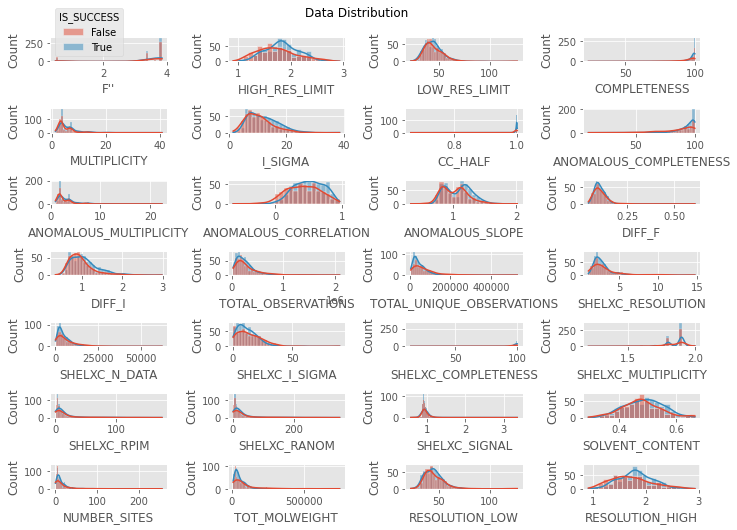

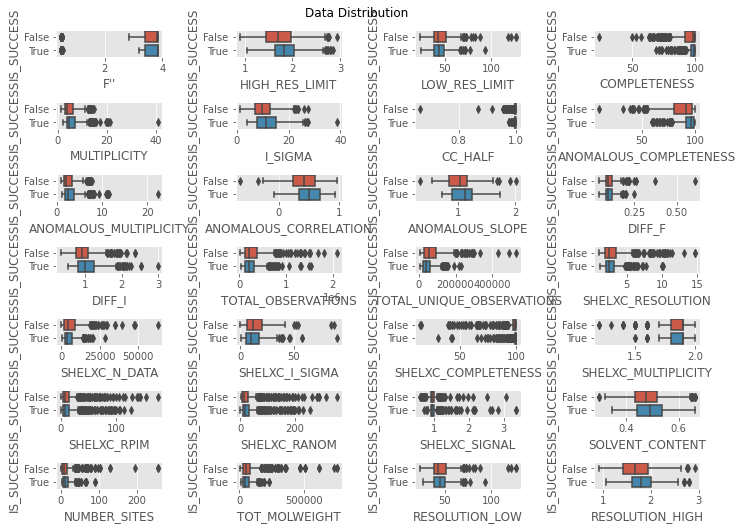

------------------------------------------------------------


In [2]:
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy.stats import sem


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)
    
    # encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)
    
    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]
    x = x.drop(["DATASET_NAME", "SPACEGROUP", "SPACEGROUP_CLUSTER"], axis=1)
    union = pd.concat([x, y], axis=1)
    
    # fit initial model
    seed = 1
    print("Seed is:", seed)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc = make_scorer(matthews_corrcoef)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)

    
    # see difference between dataset resolutions and actual resolutions
    diff_low = x["RESOLUTION_LOW"] - x["LOW_RES_LIMIT"]
    diff_high = x["RESOLUTION_HIGH"] - x["HIGH_RES_LIMIT"]
    fig, (ax_left, ax_right) = plt.subplots(1, 2, figsize=(12, 6))
    sns.histplot(data=diff_low, ax=ax_left, kde=True, bins=100)
    sns.histplot(data=diff_high, ax=ax_right, kde=True, bins=100)
    ax_left.set_xlabel("LR Difference");  ax_right.set_xlabel("HR Difference")
    ax_left.set_ylabel("Counts");  ax_right.set_ylabel("Counts")
    plt.show()

    # get initial MSE and find outliers based on simple threshold for resolution difference
    thresh_low, thresh_high = 5, 0.1
    mse_low = (diff_low ** 2).mean()
    mse_high = (diff_high ** 2).mean()
    good_low_mask = abs(diff_low) < thresh_low
    good_high_mask = abs(diff_high) < thresh_high

    # get stats for new, filtered resolution differences
    good_diff_low = diff_low[good_low_mask]
    good_diff_high = diff_high[good_high_mask]
    dropped_low = diff_low.size - good_diff_low.size
    dropped_high = diff_high.size - good_diff_high.size
    mse_good_low = (good_diff_low ** 2).mean()
    mse_good_high = (good_diff_high ** 2).mean()
    bad_mask = (np.logical_or(~good_low_mask, ~good_high_mask))

    # print results and stats
    print(f"OG:\n> Low: {diff_low.size} samples - MSE: {mse_low:.2f}\n"
          f"> High: {diff_high.size} samples - MSE: {mse_high:.4f}\n"
          f"Masked:\n> Low: {good_diff_low.size} samples - Dropped {dropped_low} ({dropped_low / diff_low.size:.2%}) - MSE: {mse_good_low:.2f}\n"
          f"> High: {good_diff_high.size} samples - Dropped {dropped_high} ({dropped_high / diff_high.size:.2%}) - MSE: {mse_good_high:.4f}\n"
          f"No. of common outliers: {(np.logical_and(~good_low_mask, ~good_high_mask)).sum()}\n"
          f"In total dropped {bad_mask.sum()} samples ({bad_mask.sum()/bad_mask.size:.2%})")

    # obtain actual outliers and filtered data
    good_mask = np.logical_and(good_low_mask, good_high_mask)
    outliers = union.loc[~good_mask, :]
    union_good = union.loc[good_mask, :]
    
    # fit new model with filtered data
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x.loc[good_mask, :], y[good_mask], scoring="f1", cv=cv, n_jobs=4)
    mcc_new = cross_val_score(model, x.loc[good_mask, :], y[good_mask], scoring=mcc, cv=cv, n_jobs=4)
    print(f"> Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
          f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}\n"
          f"> MCC: OG = {mcc_og.mean():.2f} +- {sem(mcc_og):.2f} "
          f"vs New = {mcc_new.mean():.2f} +- {sem(mcc_new):.2f} ")
    
    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(union_good, colnames=x.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()
    
    print("-"*60)

Most samples have 0 difference (optimal), however there are quite a few with observable difference (as seen by the large MSE > 20).

After dropping the large difference samples (~20%/30% for DIALS/XDS), the MSE drops to ~0.1, indicating almost **all of the erroneous resolution samples have been removed**. However, the distributions still look **similar** - most features have a "tail" in their histogram, and a significant amount of outliers in their boxplots.

However, a the following features do show less outliers in their boxplots:

- **Completeness/multiplicity**, and its variations
- **CC half**
- **Anomalous slope**, on its high end (>2)
- **DIFF F/I**
- **I sigma**
- etc.

The effect is stronger (and better) on XDS, since more outliers appear to be removed in this case. The matthews correlation coefficient, or MCC, is unchanged for DIALS, but lower for XDS.

This being said, removing these *outliers* results in **similar predictive performance**, even if slightly lower (tested with random forest), indicating that their removal does not affect model performance by a significant amount.

Care needs to be taken when choosing the LR/HR thresholds, since too small thresholds will remove too much critical data, worsening the performance, and too large thresholds will not remove any data, having no impact on performance.


**Conclusion**: This method successfully removes *some* outliers, while keeping the performance around the same, with slight drops.


## Method 2: k-factor IQR

Another statistical outlier removal method is that of the IQR method. This one uses the interquartile range (IQR), or the difference between the 75th and 25th percentile, to determine the upper and lower bounds to which to filter samples within each feature. The IQR is multiplied by a k-factor before being subtracted/added to the 25th/75th quartile, resulting in the lower/upper bounds for each feature. If a given sample has at least on their features outside of the proper range, then it is considered an outlier, and removed.

Spacegroup cluster will not be filtered due to its unique distribution. Matter of fact, since it is obtained using the success rates, by using this feature we are indirectly providing the model information regarding all of the targets, including test. As such, to prevent this, this feature will be **removed**.

DIALS
Seed is: 1
------------------------------
Hyperparameter k: 1
Features to be analysed but not filtered: ["F''"]


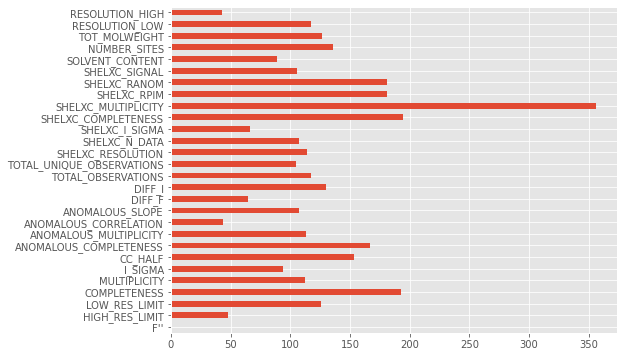

> Samples: OG = 1201 vs New = 280 - Dropped 921 (76.69%)
> Score: OG = 80.50% +- 2.35% vs New = 84.22% +- 2.04%
> MCC: OG = 0.72 +- 0.03 vs New = 0.70 +- 0.04 


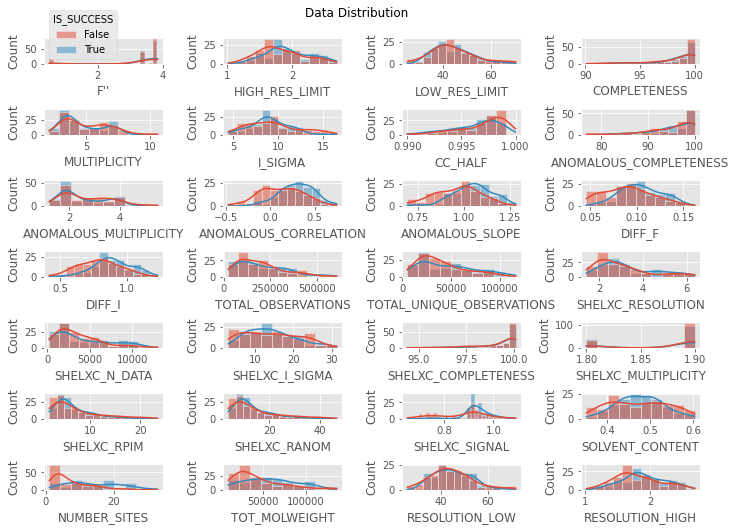

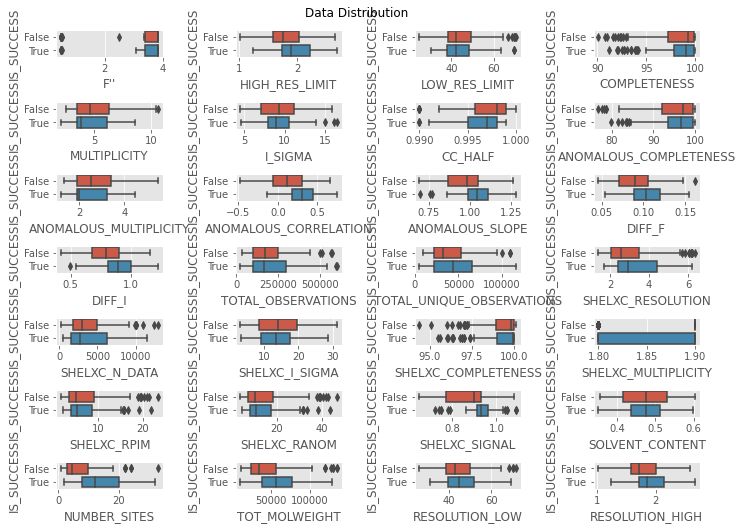

------------------------------
Hyperparameter k: 1.5
Features to be analysed but not filtered: ["F''"]


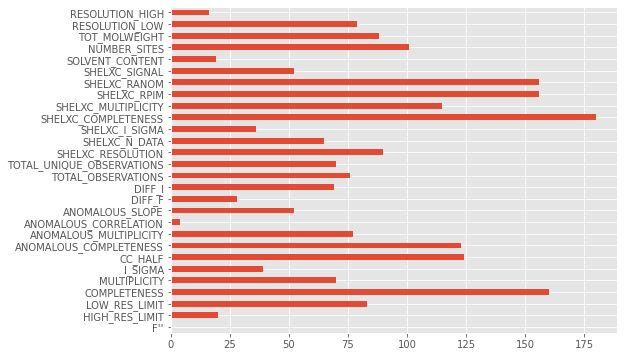

> Samples: OG = 1201 vs New = 522 - Dropped 679 (56.54%)
> Score: OG = 80.50% +- 2.35% vs New = 84.86% +- 2.06%
> MCC: OG = 0.72 +- 0.03 vs New = 0.72 +- 0.04 


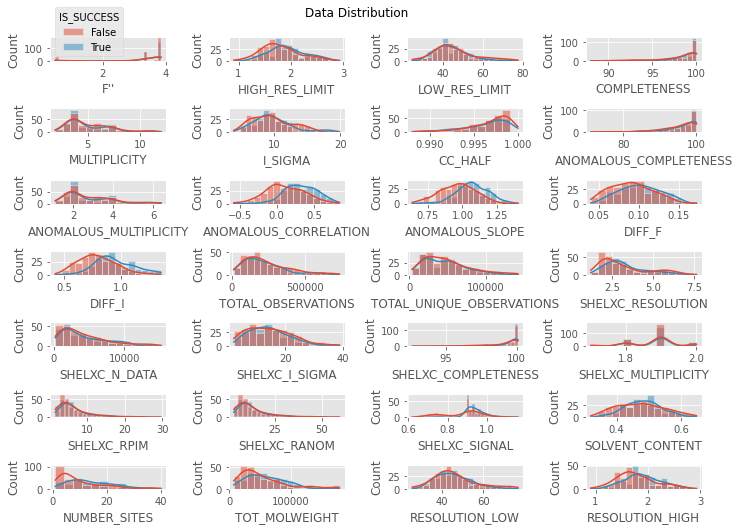

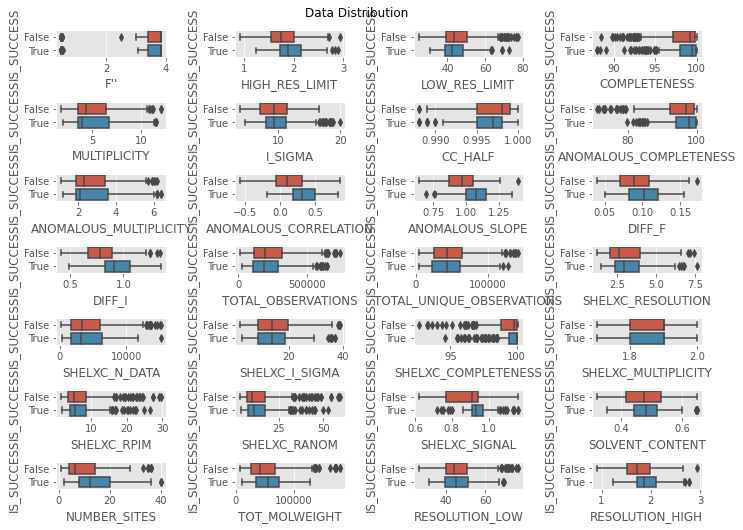

------------------------------
Hyperparameter k: 3
Features to be analysed but not filtered: ["F''"]


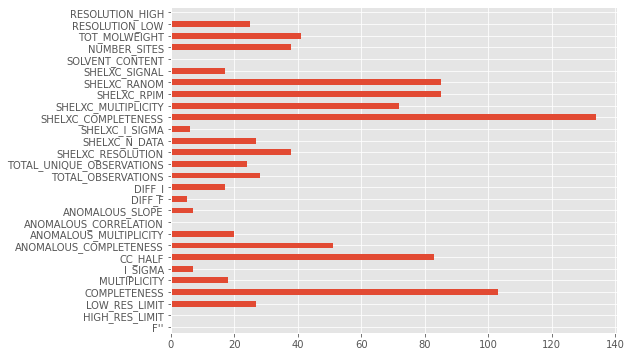

> Samples: OG = 1201 vs New = 801 - Dropped 400 (33.31%)
> Score: OG = 80.50% +- 2.35% vs New = 81.80% +- 1.95%
> MCC: OG = 0.72 +- 0.03 vs New = 0.70 +- 0.03 


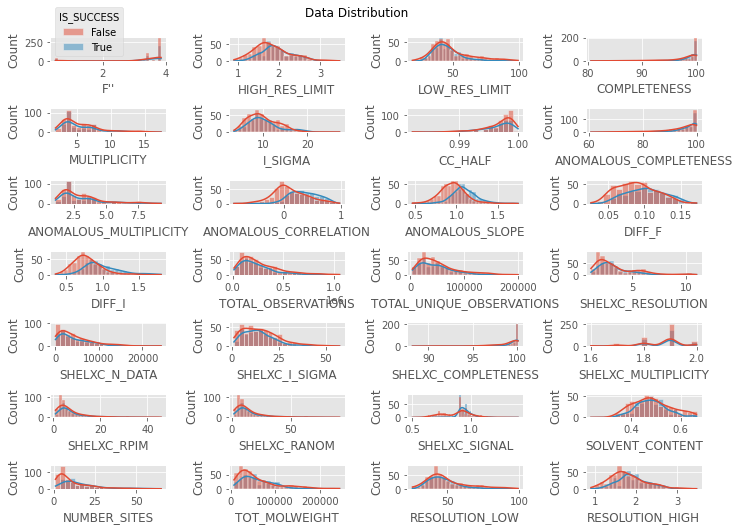

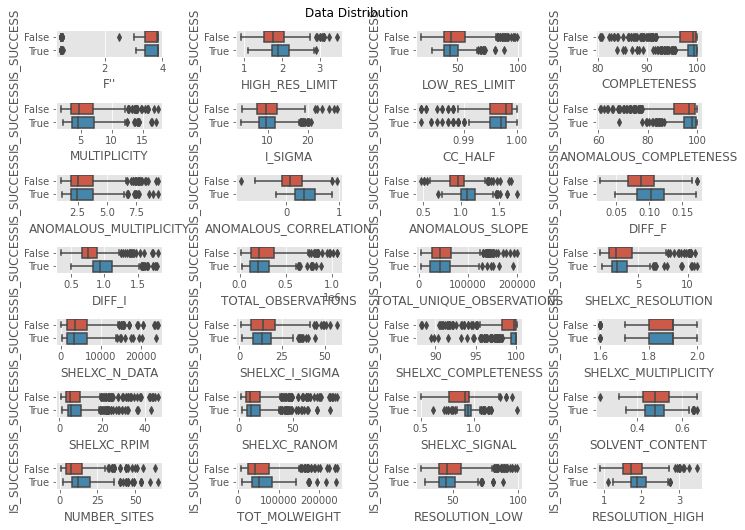

------------------------------------------------------------
3DII
Seed is: 1
------------------------------
Hyperparameter k: 1
Features to be analysed but not filtered: ["F''"]


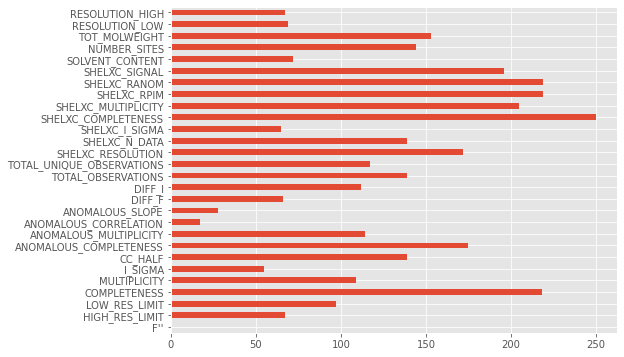

> Samples: OG = 1450 vs New = 421 - Dropped 1029 (70.97%)
> Score: OG = 88.64% +- 1.07% vs New = 87.73% +- 0.79%
> MCC: OG = 0.76 +- 0.02 vs New = 0.61 +- 0.03 


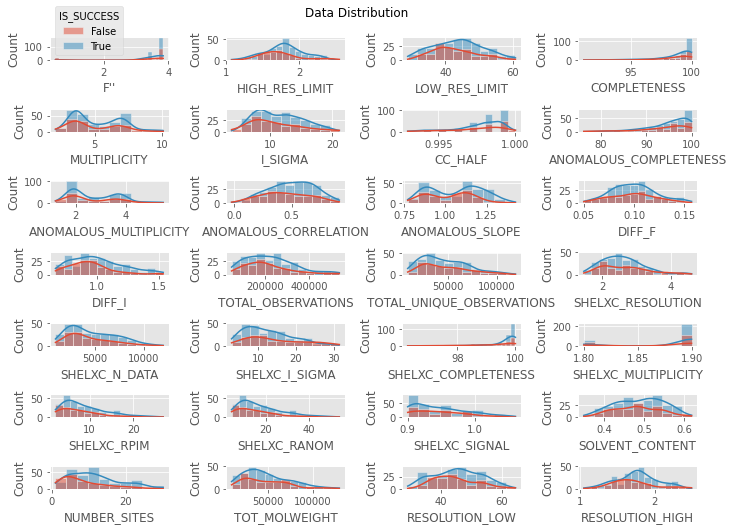

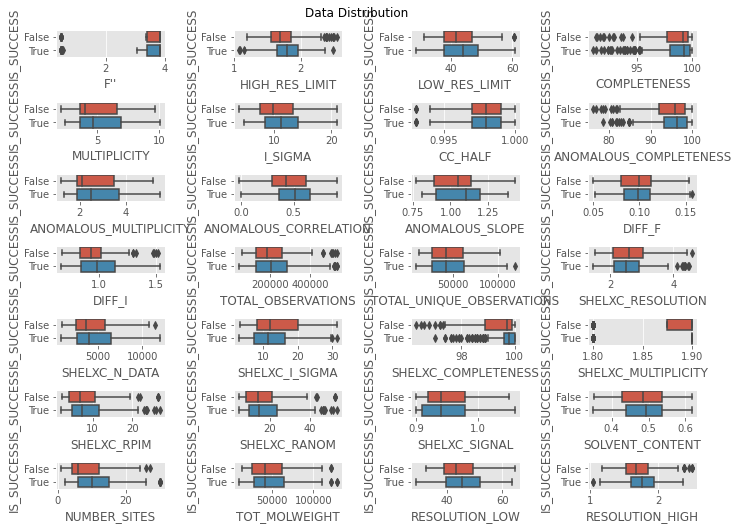

------------------------------
Hyperparameter k: 1.5
Features to be analysed but not filtered: ["F''"]


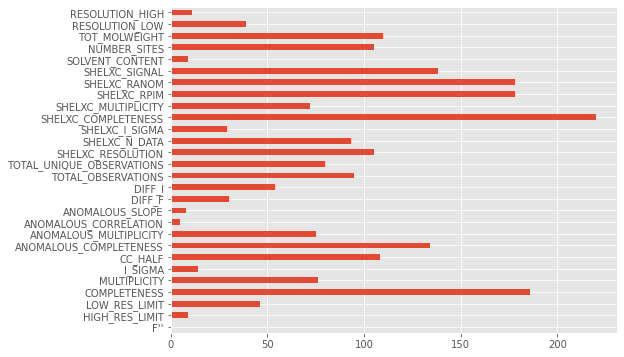

> Samples: OG = 1450 vs New = 673 - Dropped 777 (53.59%)
> Score: OG = 88.64% +- 1.07% vs New = 87.54% +- 0.59%
> MCC: OG = 0.76 +- 0.02 vs New = 0.63 +- 0.02 


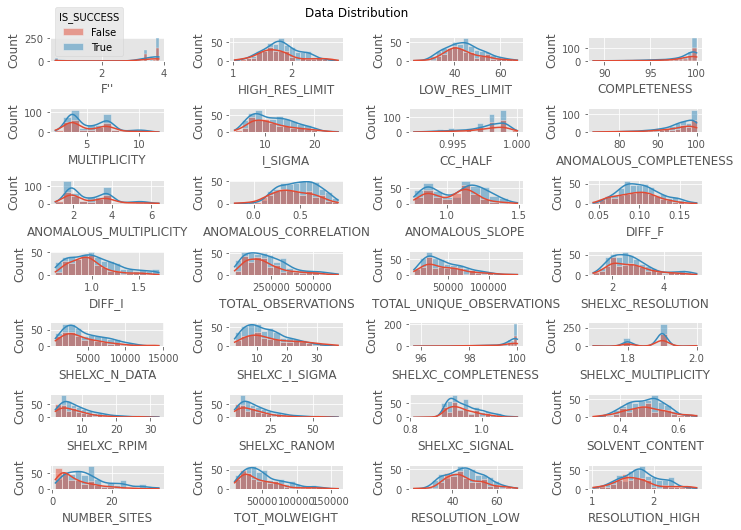

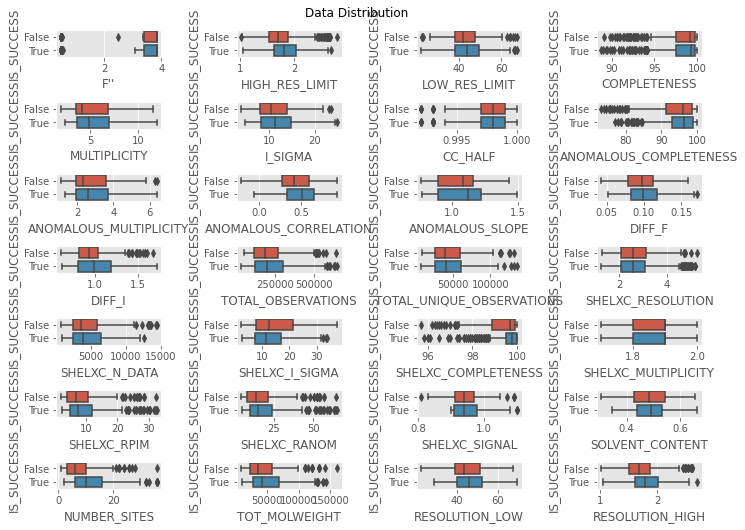

------------------------------
Hyperparameter k: 3
Features to be analysed but not filtered: ["F''"]


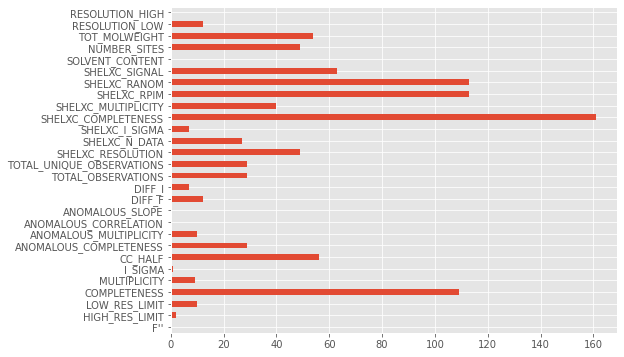

> Samples: OG = 1450 vs New = 1026 - Dropped 424 (29.24%)
> Score: OG = 88.64% +- 1.07% vs New = 87.28% +- 0.80%
> MCC: OG = 0.76 +- 0.02 vs New = 0.67 +- 0.02 


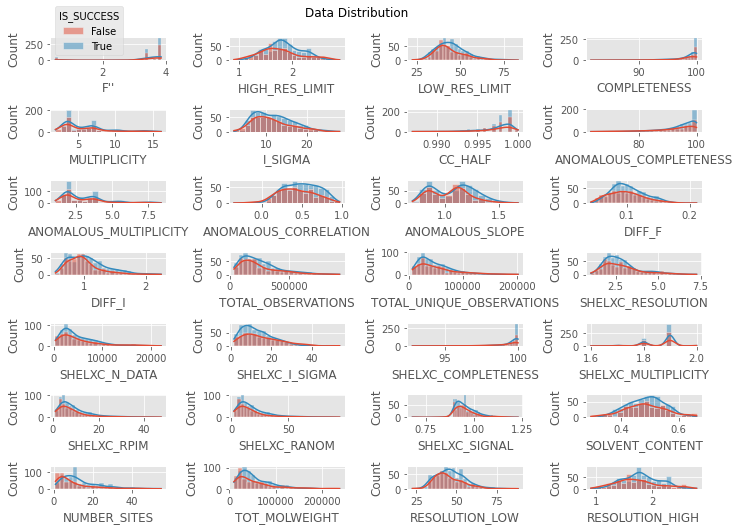

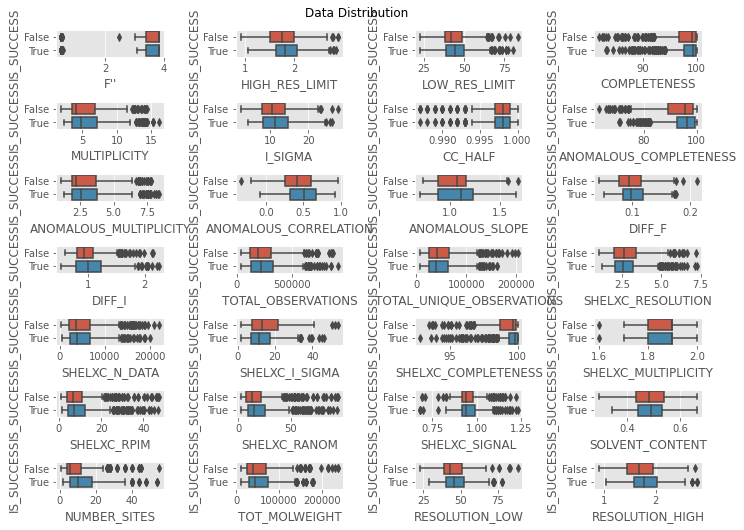

------------------------------------------------------------


In [4]:
for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    '''# encode spacegroup to int based on success rate
    n_clusters = 4 if db_kind == "dials" else 5
    _, spc_grp_map, _ = cluster_spacegroups(union, n_clusters)
    x["SPACEGROUP_CLUSTER"] = x["SPACEGROUP"].map(spc_grp_map)'''
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)


    # fit initial model
    seed = 1
    print("Seed is:", seed)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)
    
    def between_series(series, cutoffs_df, inclusive="both"):
        try:  # get values in between cutoffs
            lower, upper = cutoffs_df.loc[:, series.name]
            return series.between(lower, upper, inclusive=inclusive)
        except KeyError:  # if cutoffs not found, return series full of True
            return series == series  # might misbehave with NaN

    # lists to store number of outliers per feature
    n_outliers = []
        
    for k in [1, 1.5, 3]:
        # get 25/75th quartiles, iqr and cutoffs for all features
        print("-"*30+"\n", "Hyperparameter k: ", k, sep="")
        no_filter_cols = ["F''"]
        quarts = x.drop(no_filter_cols, axis=1).quantile([0.25, 0.75])
        print(f"Features to be analysed but not filtered: {no_filter_cols}")
        iqr = quarts.diff(axis=0).iloc[1, :].rename("IQR")
        cut_offs = quarts.copy().rename(index={0.25: "Lower", 0.75: "Upper"})
        cut_offs.iloc[0, :] -= iqr * k
        cut_offs.iloc[1, :] += iqr * k

        # obtain actual outliers and filtered data
        inliers = x.apply(between_series, axis=0, cutoffs_df=cut_offs)
        n_out = np.invert(inliers).sum(axis=0)
        n_out.plot.barh(figsize=(8,6))
        n_outliers.append(n_out)
        plt.show()
        good_mask = inliers.all(axis=1)
        # bad_mask = np.invert(good_mask)
        x_new, y_new = x.loc[good_mask, :], y[good_mask]
        union_new = union.loc[good_mask, :]
        n_og, n_new = good_mask.size, good_mask.sum()


        # fit new model with filtered data
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
        scores_new = cross_val_score(model, x_new, y_new, scoring="f1", cv=cv, n_jobs=4)
        mcc_new = cross_val_score(model, x_new, y_new, scoring=mcc, cv=cv, n_jobs=4)

        # print results and stats
        print(f"> Samples: OG = {n_og} vs New = {n_new} - Dropped {n_og-n_new} ({1-n_new/n_og:.2%})")
        print(f"> Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
              f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}\n"
              f"> MCC: OG = {mcc_og.mean():.2f} +- {sem(mcc_og):.2f} "
              f"vs New = {mcc_new.mean():.2f} +- {sem(mcc_new):.2f} ")

        # show all in histogram and boxplot, for comparison to previous
        #if k == 1.5:
        for kind in ["hist", "box"]:
            matrixdistplot(union_new, colnames=x.columns, target_label="IS_SUCCESS", kind=kind, show=False)
            #matrixdistplot(union.loc[bad_mask, :], colnames=x.columns, title="Outlier Distribution",target_label="IS_SUCCESS", kind=kind, show=False)
        plt.show()

    print("-" * 60)

The histograms/boxplots for k=1.5 show **much better distributions**. Most features show a more gaussian-like shape with shorter tails on the histograms, and less outlier dots on the boxplots, for both DIALS and XDS.

This method drops a significant portion of samples, of around 75%/60%/37%, resulting in a **f1 performance improvement** of 1%/4%/0% for k=1/1.5/3 for **DIALS**. Having positive (or even neutral) performance increase when removing such a large amount of samples indicates the significant presence of outliers within the data. 

**XDS** has an unfiltered score ~8% higher than DIALS, and **does not benefit** from the outlier removal process. This likely indicates at the low outlier presence within XDS, confirming its higher quality over DIALS.

A few features show a higher percentage of outliers than others. These are: **completeness/multiplicity** (and variations), **CC half** and **SHELXC RANOM/RPIM**

If k is too small (k=1), too much data is removed, and the performance hurts as a result. If k is too large (k=3), too little data is removed, and the performance remains the same. As such, the **optimal k-factor would be 1.5**, which gives the best balance between performance increase and data removal.

Surprisingly, even though the f1 score improved, the **MCC remained constant or even decreased** for every outlier removal, especially for XDS. This decrease is the least for k=1.5, and biggest for k=1 (averaged over other random states).

Removing the SPACEGROUP_CLUSTER feature resulted in an 8% performance loss for method 1, and a 1% increase for method 2.


## Method 3: Robust Covariance

While method 2 is based on quartiles, this method is based on continuous, normal distributions. This method assumes the data follows a **gaussian distribution**, and uses the covariance to identify an n-dimensional elipsoid from which outliers are found (outside of this elipsoid are outliers, inside are inliers). In sklearn this algorithm is called EllipticEnvelope.

As such, not all features are suited for this method (such as completeness, which is capped at 100, and only shows a trail bellow this value).

This method requires an hyperparameter called **contamination**, which determines the percentage of samples to be labeled as outliers. For best possible performance, this hyperparameter ought to be searched through and the best value found.

DIALS
Seed is: 1
Current contamination: 0.75 (100.00%)


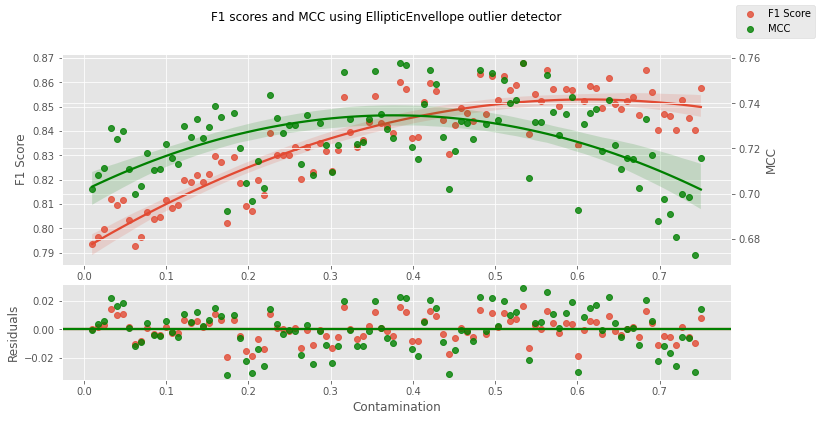

------------------------------------------------------------
3DII
Seed is: 1
Current contamination: 0.75 (100.00%)


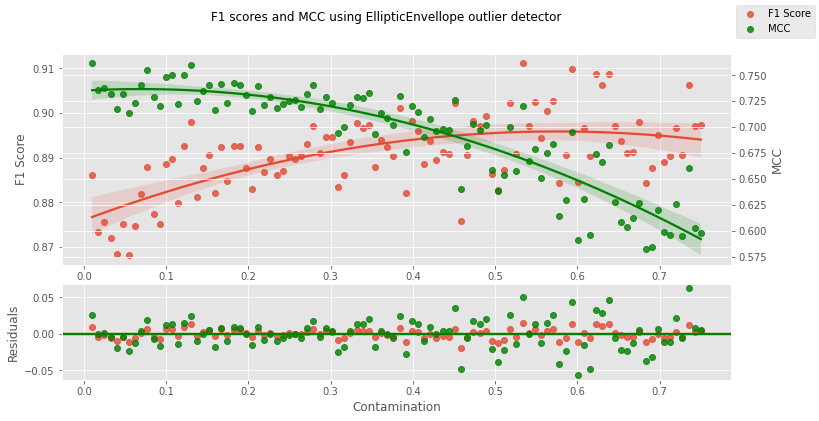

------------------------------------------------------------


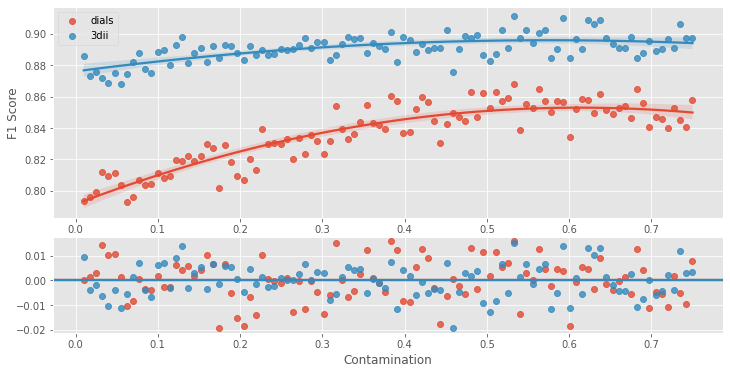

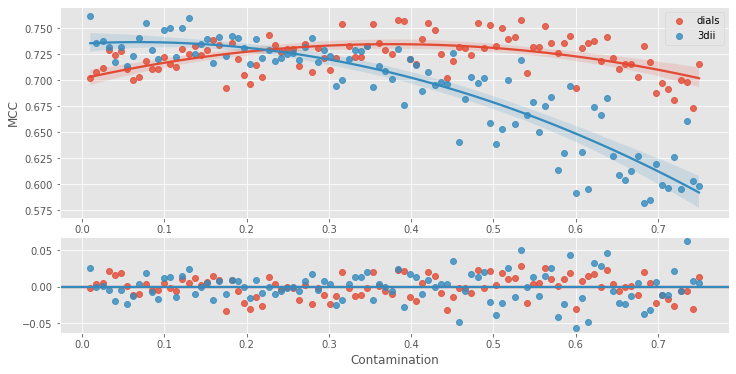

In [12]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier


scores_dict, mccs_dict = {}, {}


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    # encode spacegroup to int based on success rate
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)
    
    # test old data
    print("Seed is:", seed)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)

    # prepare variables to store info on contamination performance
    n = 100
    contam_lims = (0.01, 0.75)
    contam_range = np.linspace(*contam_lims, n)
    scores, mccs = [], []
    no_filter_cols = ["F''"]

    
    for contam in contam_range:
        # detect outliers
        end = "\n" if contam == contam_lims[1] else ""
        print(f"\rCurrent contamination: {contam:.2f} ({(contam-contam_lims[0])/np.diff(contam_lims)[0]:.2%})", end=end)
        detector = EllipticEnvelope(support_fraction=1, contamination=contam, random_state=seed)  # get runtime warnings if support_fraction != 1
        liers = detector.fit_predict(x.drop(no_filter_cols, axis=1))

        # filter new values based on outlier detector results
        mask = liers != -1
        x_new, y_new = x.loc[mask, :], y[mask]
        n_og, n_new = mask.size, mask.sum()

        # test new data
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
        model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
        scores_test = cross_val_score(forest_search, x_new, y_new, scoring="f1", cv=cv, n_jobs=4)
        mcc_test = cross_val_score(forest_search, x_new, y_new, scoring=mcc, cv=cv, n_jobs=4)
        
        scores.append(scores_test.mean())
        mccs.append(mcc_test.mean())

    # save results
    scores_dict[db_kind] = scores
    mccs_dict[db_kind] = mccs
        
    # prepare figure
    fig = plt.figure(figsize=(12, 6))
    gs = fig.add_gridspec(3)
    ax_main = fig.add_subplot(gs[:2])
    ax_sec = ax_main.twinx()
    ax_res = fig.add_subplot(gs[2], sharex=ax_main)
    
    # plot main - f1 score vs contamination
    sns.regplot(x=contam_range, y=scores, order=2, ax=ax_main, label="F1 Score")
    ax_main.set_ylabel("F1 Score")
    
    # plot secondary - n_samples vs contamination
    sns.regplot(x=contam_range, y=mccs, order=2, ax=ax_sec, color="g", label="MCC")
    ax_sec.set_ylabel("MCC")
    fig.legend()
    
    # plot residuals
    sns.residplot(x=contam_range, y=scores, order=2, lowess=True, ax=ax_res)
    sns.residplot(x=contam_range, y=mccs, order=2, lowess=True, ax=ax_res, color="g")
    ax_res.set_xlabel("Contamination")
    ax_res.set_ylabel("Residuals")
    fig.suptitle(f"F1 scores and MCC using EllipticEnvellope outlier detector")
    plt.show()
    
    print("-"*60)


# prepare F1 score/MCC only figures
fig_f1 = plt.figure(figsize=(12, 6))
gs_f1 = fig_f1.add_gridspec(3)
ax_main_f1 = fig_f1.add_subplot(gs_f1[:2])
ax_res_f1 = fig_f1.add_subplot(gs_f1[2], sharex=ax_main)
fig_mcc = plt.figure(figsize=(12, 6))
gs_mcc = fig_mcc.add_gridspec(3)
ax_main_mcc = fig_mcc.add_subplot(gs_mcc[:2])
ax_res_mcc = fig_mcc.add_subplot(gs_mcc[2], sharex=ax_main)

# plot f1 score and residuals
for k, v in scores_dict.items():
    sns.regplot(x=contam_range, y=v, order=2, ax=ax_main_f1, label=k)
    sns.residplot(x=contam_range, y=v, order=2, lowess=True, ax=ax_res_f1)
for k, v in mccs_dict.items():
    sns.regplot(x=contam_range, y=v, order=2, ax=ax_main_mcc, label=k)
    sns.residplot(x=contam_range, y=v, order=2, lowess=True, ax=ax_res_mcc)

# labels
ax_main_f1.set_ylabel("F1 Score")
ax_res_f1.set_xlabel("Contamination")
ax_main_mcc.set_ylabel("MCC")
ax_res_mcc.set_xlabel("Contamination")
ax_main_f1.legend()
ax_main_mcc.legend()


plt.show()

Both databases show an increase in **f1** performance during the initial contamination increase. But they also both reach a contamination "threshold", from which point the performance remains relatively constant (within the statistical variation).

For DIALS/XDS these thresholds are roughly 0.4/0.2, meaning that, by this outlier detector, **around 40%/20% of DIALS/XDS data can be considered outliers**.

However, **MCC** tells a different story. DIALS' MCC shows a **maximum at ~0.35-0.4** contamination, decreasing at the edges, confirming what was already found. For XDS it behaves exactly the opposite as the f1 score. It starts off at its maximum, remaining relatively **constant until around 0.2**, from where it starts decreasing.

A 2nd order polynomial fits really well to the data. DIALS shows an observable f1 score increase and relatively constant MCC, while XDS shows the opposite, with a constant f1 score and decreasing MCC. As such, **DIALS appears to benefit from outlier removal, unlike XDS**.

From the plots above, **ideal contaminations** of 0.4/0 are chosen for DIALS/XDS.

DIALS
Seed is: 1
Best contamination: 0.4
> Score: OG = 80.50% +- 2.35% vs New = 84.84% +- 2.88%
> MCC: OG = 0.72 +- 0.03 vs New = 0.74 +- 0.05


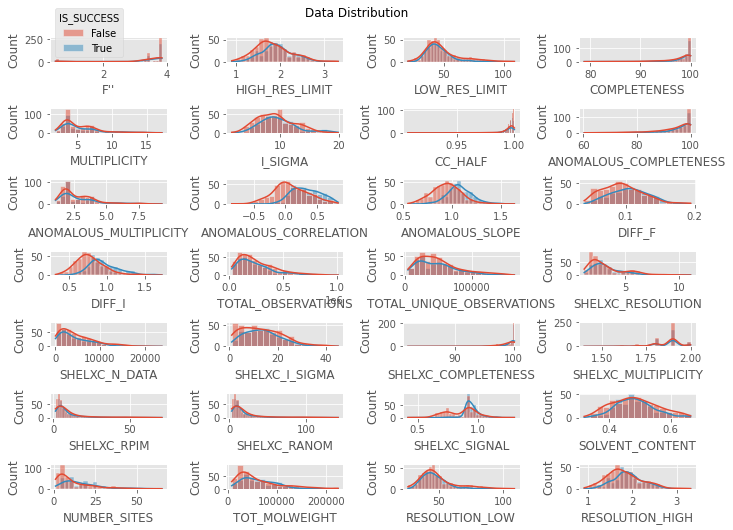

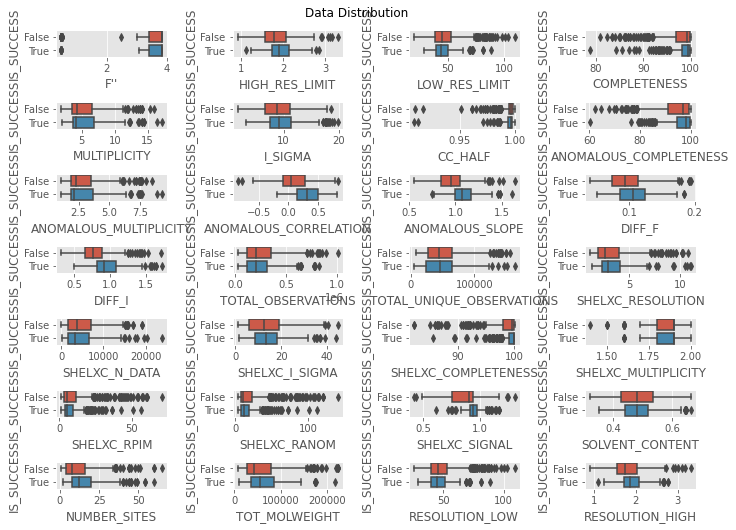

------------------------------------------------------------
3DII
Seed is: 1
Best contamination: 0.2
> Score: OG = 88.64% +- 1.07% vs New = 88.93% +- 0.88%
> MCC: OG = 0.76 +- 0.02 vs New = 0.73 +- 0.02


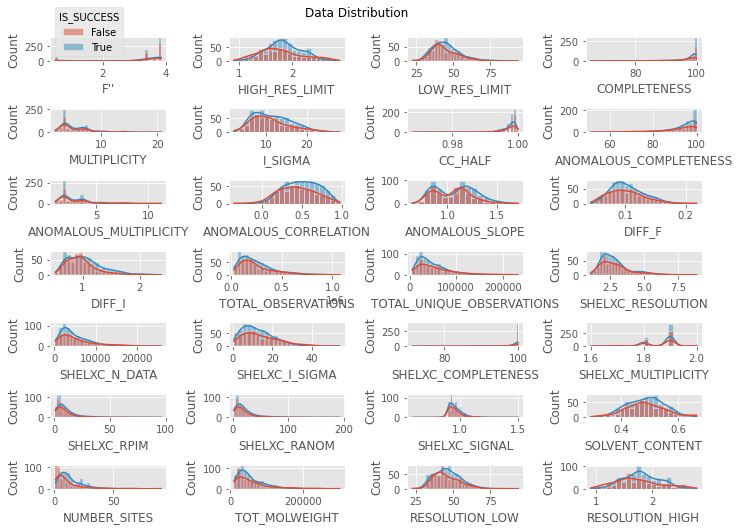

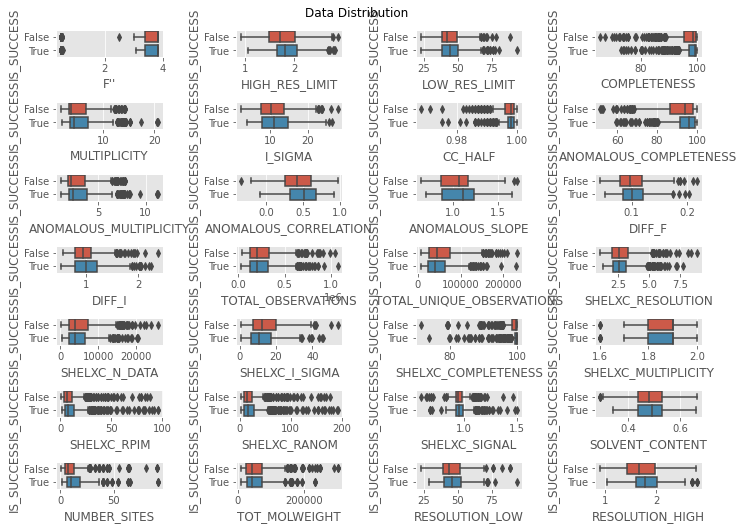

------------------------------------------------------------


In [80]:
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import PowerTransformer, QuantileTransformer
from sklearn.pipeline import Pipeline


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    # encode spacegroup to int based on success rate
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)
    seed = 1
    print("Seed is:", seed)
    
    
    # test old data
    scaler = StandardScaler
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", scaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)

    # choose balanced contamination and filter data
    best_contam = 0.4 if db_kind == "dials" else 0.2
    print(f"Best contamination: {best_contam}")
    detector = EllipticEnvelope(support_fraction=1, contamination=best_contam, random_state=seed)
    liers = detector.fit_predict(x)
    mask = liers != -1
    x_new, y_new, union_new = x.loc[mask, :], y[mask], union.loc[mask, :]
    n_og, n_new = mask.size, mask.sum()

    # get new scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", scaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x_new, y_new, scoring="f1", cv=cv, n_jobs=4)
    mcc_new = cross_val_score(model, x_new, y_new, scoring=mcc, cv=cv, n_jobs=4)

    
    # print results and stats
    print(f"> Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
          f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}\n"
          f"> MCC: OG = {mcc_og.mean():.2f} +- {sem(mcc_og):.2f} "
          f"vs New = {mcc_new.mean():.2f} +- {sem(mcc_new):.2f}")

    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(union_new, colnames=x_new.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()
    
    print("-"*60)

Comparing to the initial, unfiltered data, these distributions also show an **improvement**. The histograms look more gaussian-like and have shorter tails, and there are also less dot outliers on the boxplots.

More concretely, this method drops 40%/20% samples, resulting in a 4%/0.3% f1 performance increase (0.02/0.03 MCC increase/decrease) for DIALS/XDS, resulting in **approximately the same performance**. It's the first method so far to result in a positive f1 performance increase for XDS, which is not observed in the MCC, indicating that the XDS performance did not, in fact, improve.


## Method 4: Isolation Forests

This method uses a random forest specially designed to identify isolated samples, or anomalies. It is effective in high dimensions, and doesn't assume the data follows a certain distribution, unlike method 3.

DIALS
Seed is: 1
Best contamination: 0.4
Using outlier detector: IsolationForest(contamination=0.4, random_state=1)
Actual contamination: 39.97%
> Score: OG = 80.50% +- 2.35% vs New = 83.49% +- 1.48%
> MCC: OG = 0.72 +- 0.03 vs New = 0.72 +- 0.02


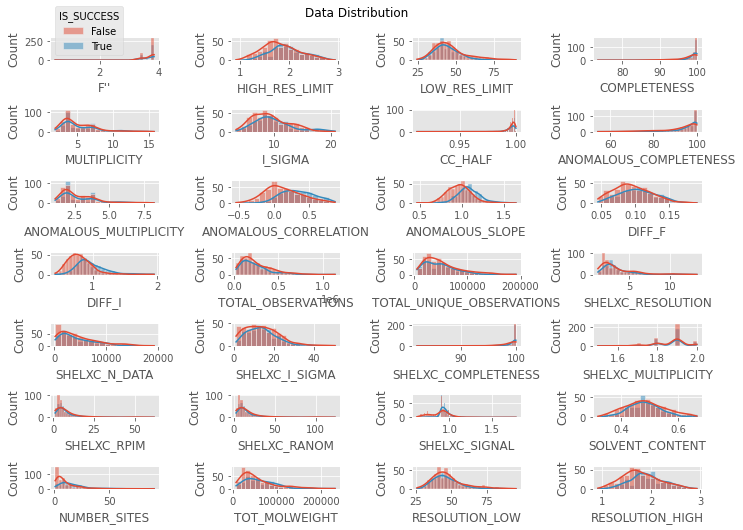

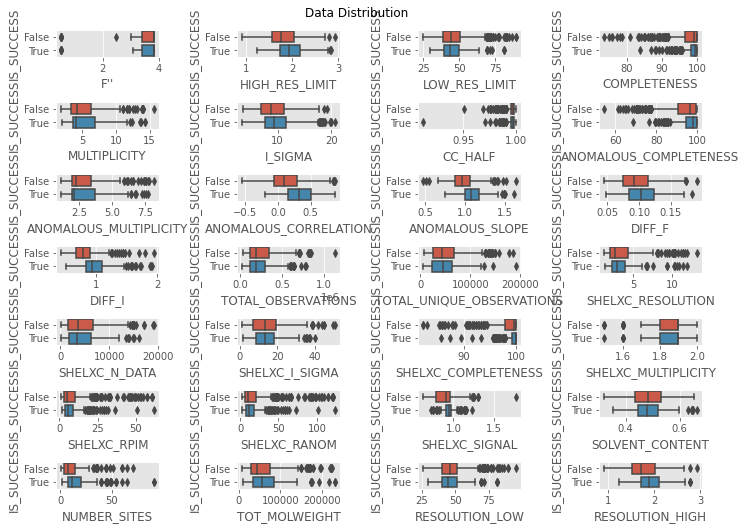

------------------------------------------------------------
3DII
Seed is: 1
Best contamination: 0.2
Using outlier detector: IsolationForest(contamination=0.2, random_state=1)
Actual contamination: 20.00%
> Score: OG = 88.64% +- 1.07% vs New = 89.05% +- 0.71%
> MCC: OG = 0.76 +- 0.02 vs New = 0.74 +- 0.02


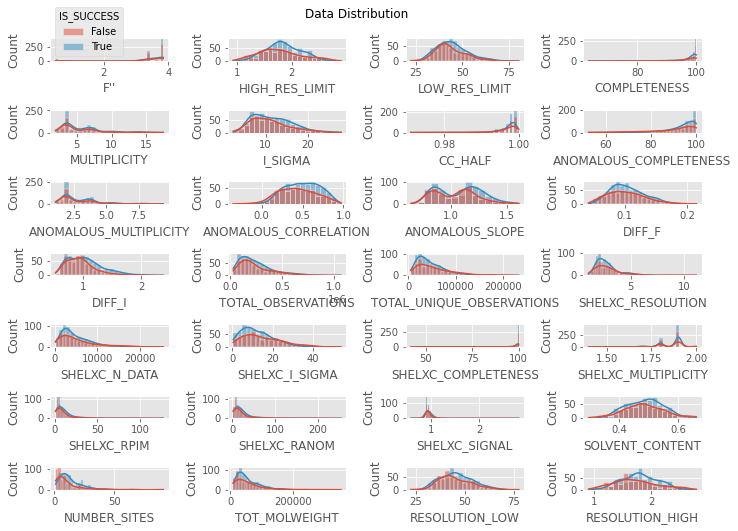

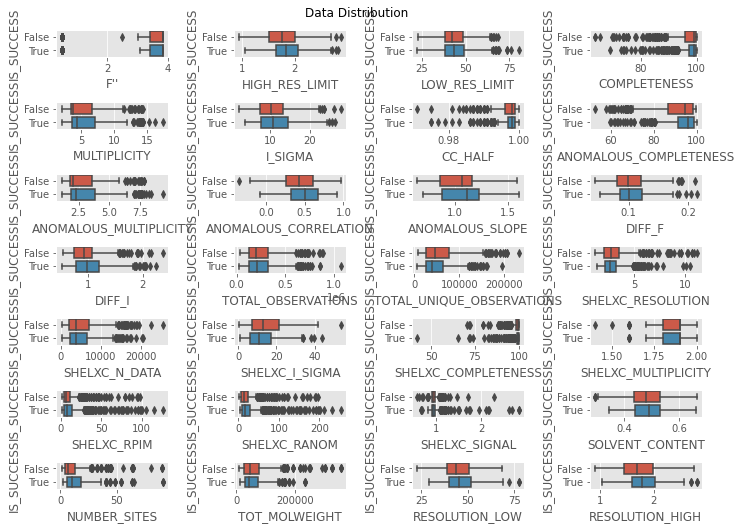

------------------------------------------------------------


In [85]:
from sklearn.ensemble import IsolationForest


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    # encode spacegroup to int based on success rate
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)
    seed = 1
    print("Seed is:", seed)
    
    # test old data
    scaler = StandardScaler
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)

    # choose balanced contamination and filter data
    best_contam = 0.4 if db_kind == "dials" else 0.2
    print(f"Best contamination: {best_contam}")
    detector = IsolationForest(contamination=best_contam, random_state=seed)
    print(f"Using outlier detector: {detector}")
    liers = detector.fit_predict(x)
    mask = liers != -1
    x_new, y_new, union_new = x.loc[mask, :], y[mask], union.loc[mask, :]
    n_og, n_new = mask.size, mask.sum()
    print(f"Actual contamination: {1-mask.sum()/mask.size:.2%}")
    
    # get new scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", scaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x_new, y_new, scoring="f1", cv=cv, n_jobs=4)
    mcc_new = cross_val_score(model, x_new, y_new, scoring=mcc, cv=cv, n_jobs=4)

    
    # print results and stats
    print(f"> Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
          f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}\n"
          f"> MCC: OG = {mcc_og.mean():.2f} +- {sem(mcc_og):.2f} "
          f"vs New = {mcc_new.mean():.2f} +- {sem(mcc_new):.2f}")

    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(union_new, colnames=x_new.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()

    
    print("-"*60)

Changing from an EllipticEnvelope to an IsolationForest resulted in a very slight performance decrease for both DIALS and XDS.

The distributions are better than the unfiltered ones, however some of them still show a significant amount of outliers.

If the contamination if set to "auto", then it will be set to ~5%, and the performance change will be minimal.


## Method 5: Local Outlier Factor - LOF

k-neighbours applied to isolation.

DIALS
Seed is: 1
Best contamination: 0.4
Using outlier detector: LocalOutlierFactor(contamination=0.4)
Actual contamination: 39.97%
> Score: OG = 80.50% +- 2.35% vs New = 84.43% +- 2.23%
> MCC: OG = 0.72 +- 0.03 vs New = 0.76 +- 0.03


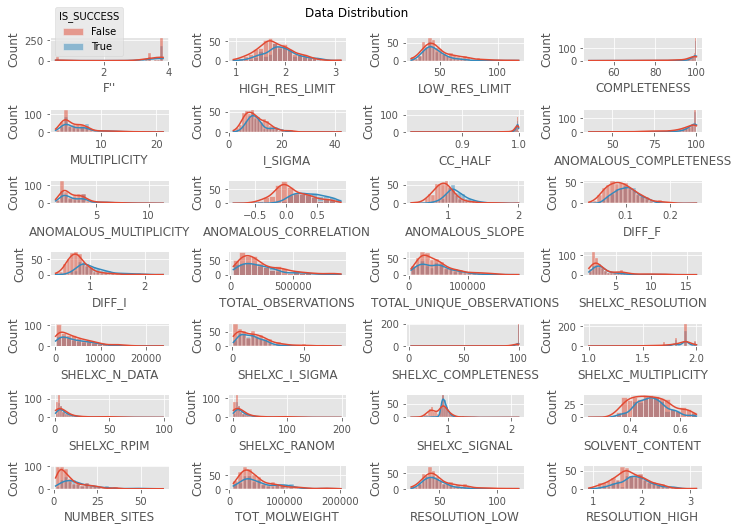

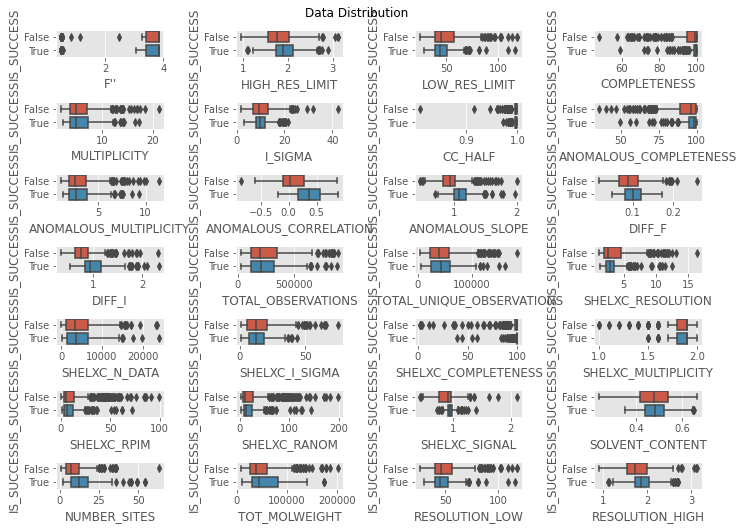

------------------------------------------------------------
3DII
Seed is: 1
Best contamination: 0.2
Using outlier detector: LocalOutlierFactor(contamination=0.2)
Actual contamination: 20.00%
> Score: OG = 88.64% +- 1.07% vs New = 89.30% +- 0.71%
> MCC: OG = 0.76 +- 0.02 vs New = 0.74 +- 0.02


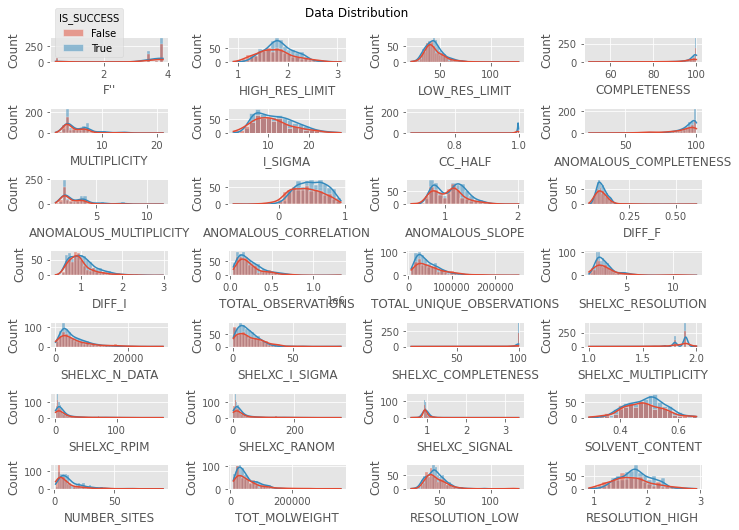

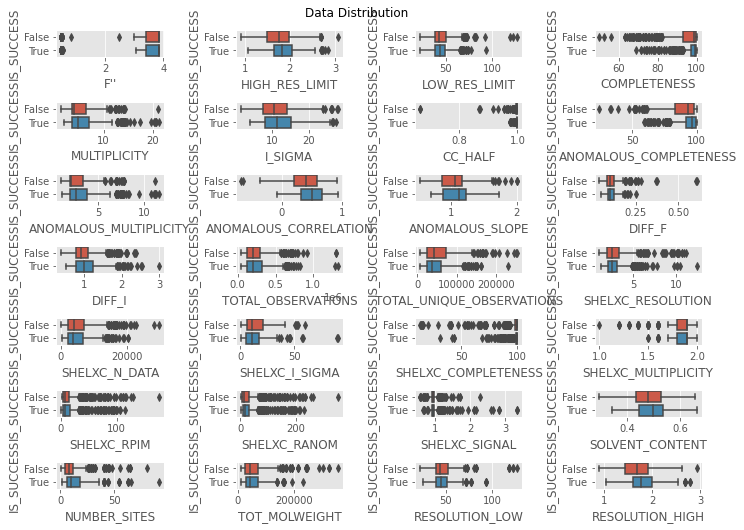

------------------------------------------------------------


In [87]:
from sklearn.neighbors import LocalOutlierFactor


for db_kind, datum in data.items():
    print(db_kind.upper())
    r_etc = ["RMERGE_I", "RMERGE_DIFF_I", "RMEAS_I", "RMEAS_DIFF_I", "RPIM_I", "RPIM_DIFF_I"]
    x, y, union = datum.unpack(drop_col=["DATASET_id", "SHELXC_CFOM"] + r_etc, union=True)

    # take only untouched data
    i = 1
    mask = x["DATASET_NAME"] == i
    x, y, = x[mask], y[mask]

    # encode spacegroup to int based on success rate
    x = x.drop(["DATASET_NAME", "SPACEGROUP"], axis=1)
    union = pd.concat([x, y], axis=1)
    seed = 1
    print("Seed is:", seed)
    
    # test old data
    scaler = StandardScaler
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", StandardScaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_og = cross_val_score(model, x, y, scoring="f1", cv=cv, n_jobs=4)
    mcc_og = cross_val_score(model, x, y, scoring=mcc, cv=cv, n_jobs=4)

    # choose balanced contamination and filter data
    best_contam = 0.4 if db_kind == "dials" else 0.2
    print(f"Best contamination: {best_contam}")
    detector = LocalOutlierFactor(contamination=best_contam)
    print(f"Using outlier detector: {detector}")
    liers = detector.fit_predict(x)
    mask = liers != -1
    x_new, y_new, union_new = x.loc[mask, :], y[mask], union.loc[mask, :]
    n_og, n_new = mask.size, mask.sum()
    print(f"Actual contamination: {1-mask.sum()/mask.size:.2%}")
    
    # get new scores
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    model = Pipeline([("scaler", scaler()), ("forest", RandomForestClassifier(random_state=seed))])
    scores_new = cross_val_score(model, x_new, y_new, scoring="f1", cv=cv, n_jobs=4)
    mcc_new = cross_val_score(model, x_new, y_new, scoring=mcc, cv=cv, n_jobs=4)

    
    # print results and stats
    print(f"> Score: OG = {scores_og.mean():.2%} +- {sem(scores_og):.2%} "
          f"vs New = {scores_new.mean():.2%} +- {sem(scores_new):.2%}\n"
          f"> MCC: OG = {mcc_og.mean():.2f} +- {sem(mcc_og):.2f} "
          f"vs New = {mcc_new.mean():.2f} +- {sem(mcc_new):.2f}")

    # show all in histogram and boxplot, for comparison to previous
    for kind in ["hist", "box"]:
        matrixdistplot(union_new, colnames=x_new.columns, target_label="IS_SUCCESS", kind=kind, show=False)
    plt.show()

    
    print("-"*60)

If contamination is set to auto then it will be around 2% or 1% with minimal performance change.